# Using imgui bundle scatter widget with Fiatlight

In [1]:
# cf  https://www.youtube.com/watch?v=STPv0jSAQEk&list=PLSIzlWDI17bS025ph6R0W_3RKM0qJ3qoO&index=4


## Import dependencies

In [10]:
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pylab as plt 
from matplotlib.figure import Figure
import numpy as np
from enum import Enum
import pandas as pd
import time

# Specific imports for fiatlight
import fiatlight as fl
from scatter_widget_bundle import ScatterData


## Use the widget

Here we simply show how to use the scatter widget with Fiatlight.
For this, we simply create a function `scatter_source(ScatterData) -> ScatterData`,  and we run it via Fiatlight.

Fiatlight will then let us enter the input data for this function.

Notes: 
- Fiatlight automatically saves the data: they will be saved into `fiat_settings/scatter_source.fiat_user_json` 
  (the filename scatter_source comes from the `app_name` below).

This means that upon restarting the kernel, the data will be loaded back in.

As a consequence, this notebook is provided with all the data already entered. The scatters you will see below will be populated with the data present in the `fiat_settings/` folder!

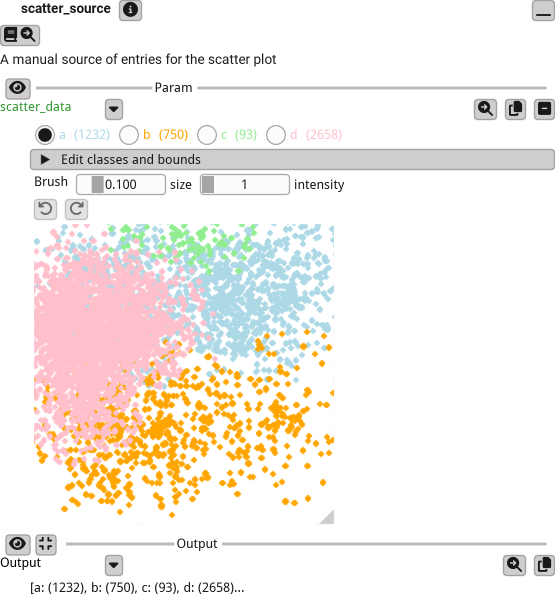

In [3]:
def scatter_source(scatter_data: ScatterData) -> ScatterData:
    """A manual source of entries for the scatter plot"""
    return scatter_data

fl.run(scatter_source, app_name="scatter_source")

## Input scatter data and draw a decision boundary from it

In this case, we will compose two functions: `scatter_source` and `plot_boundary` to draw a decision boundary from the input scatter data.

### Define `plot_boundary`

First we define `DecisionStrategy`, an enum with different strategies to draw the decision boundary.

Then we define `plot_boundary` that will take the scatter data and draw a decision boundary from it. It returns a matplotlib figure.
It accepts two parameters:
- strategy: the strategy to use to draw the boundary
- eps: the epsilon value to use for the decision boundary

In [4]:
class DecisionStrategy(Enum):
    """This is a simple enum to choose between logistic regression and decision tree
    Fiatlight will automatically convert this to radio buttons in the UI
    """
    logistic_regression = LogisticRegression
    decision_tree = DecisionTreeClassifier


@fl.with_fiat_attributes(eps__range = (0.01, 10))
def plot_boundary(df: pd.DataFrame, strategy: DecisionStrategy, eps: float=1.0) -> Figure | None:
    """This function will plot the decision boundary of a classifier on a 2D dataset
    * df is a DataFrame with columns 'x', 'y', 'color'
    * strategy is a DecisionStrategy enum (choose between logistic regression and decision tree)
    * eps is the step size in the meshgrid

    It is decorated with `@fl.with_fiat_attributes(eps__range = (0.01, 10))` which means that the 
    eps argument will be exposed in the UI as a slider with a range from 0.01 to 10.
    """
    if len(df) and (df['color'].nunique() > 1):
        X = df[['x', 'y']].values
        y = df['color']
        fig, ax = plt.subplots()
        if strategy == DecisionStrategy.logistic_regression:
            classifier = LogisticRegression().fit(X, y)
        else:
            classifier = DecisionTreeClassifier().fit(X, y)
        disp = DecisionBoundaryDisplay.from_estimator(
            classifier, X,
            response_method="predict_proba" if len(np.unique(df['color'])) == 2 else "predict",
            xlabel="x", ylabel="y",
            #alpha=0.5,
            eps=eps,
            ax=ax
        )
        disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
        ax.set_title(f"{classifier.__class__.__name__}")
        return fig
    else:
        return None


## Use plot_boundary with Fiatlight

We simply run a function composition with `scatter_source`, `scatter_data_to_df`, and `plot_boundary` to draw the decision boundary from the input scatter data.

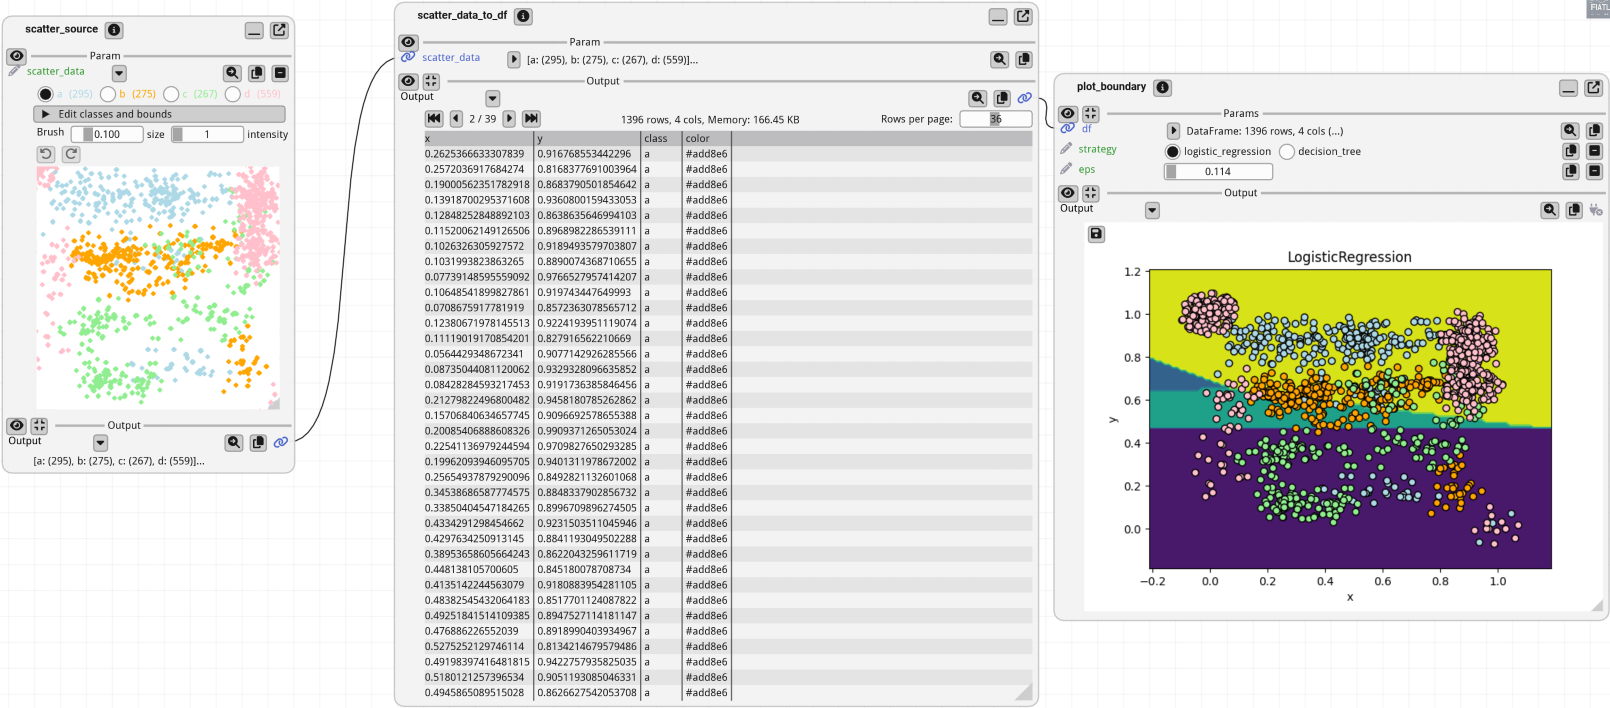

In [5]:
def scatter_data_to_df(scatter_data: ScatterData) -> pd.DataFrame:
    """Simple function to convert the scatter data to a DataFrame"""
    return scatter_data.data_as_pandas()


fl.run([scatter_source, scatter_data_to_df, plot_boundary], app_name="plot_boundary")

# How to get back data from Fiatlight

As we have seen, Fiatlight operates mostly with pure functions. Each call to fiatlight.run() before did save/reload its state, but it is inaccessible from the outside.

Pure functions are nice, but how do we get back the data from Fiatlight?

The answer is simple: we can define a sink function that will take the data and store it into a global variable (SCATTER_DATA in this case).


> Note: FiatLight has an extremely powerful utility: it can save its state. 
> 
> **This means that when you running the cell below, you can load one of the saved states and continue from there**
>
> The global variable SCATTER_DATA will then be populated with the data from the saved state.
> 
> Try and load a saved state: Menu "File/Load user inputs" and select a file inside the "saved_states" folder.

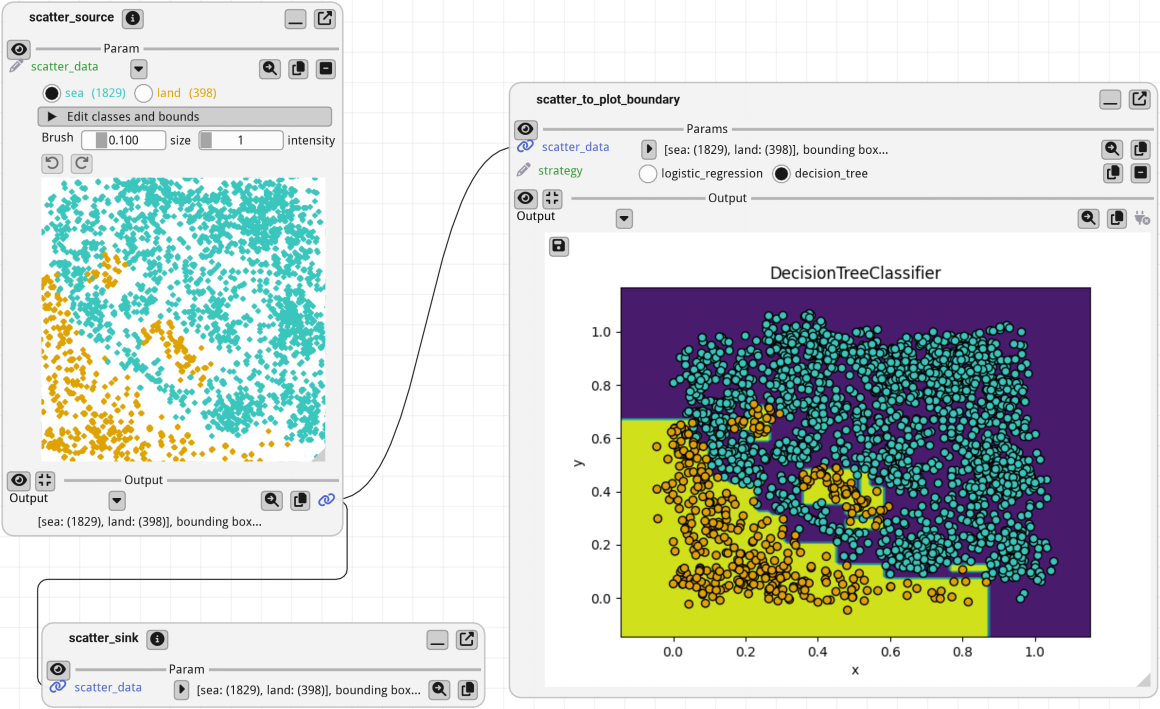

In [6]:
# Let's define a global variable to store the scatter data
SCATTER_DATA = ScatterData.make_default()

# And let's define a sink that will update this global variable
def scatter_sink(scatter_data: ScatterData) -> None:
    """This function does nothing but update the global variable SCATTER_DATA"""
    global SCATTER_DATA
    SCATTER_DATA = scatter_data

# Additionally, we will compose scatter_data_to_df, plot_boundary (to save space on the graph)
def scatter_to_plot_boundary(scatter_data: ScatterData, strategy: DecisionStrategy) -> Figure | None:
    return plot_boundary(scatter_data.data_as_pandas(), strategy=strategy, eps=0.1)

# And now let's define a slightly more complex function graph where we will add this sink
graph = fl.FunctionsGraph()
graph.add_function_composition([scatter_source, scatter_to_plot_boundary])
graph.add_function(scatter_sink)
graph.add_link(scatter_source, scatter_sink)
fl.run(graph, app_name="store_scatter_as_global")


**And now we have our global variable with the data!**

In [7]:
SCATTER_DATA.data_as_pandas()

,x,y,class,color
0,0.790902,0.843732,sea,#3ac5bd
1,0.764674,0.782618,sea,#3ac5bd
2,0.793630,0.795177,sea,#3ac5bd
3,0.804423,0.893387,sea,#3ac5bd
4,0.797252,0.891089,sea,#3ac5bd
...,...,...,...,...
2222,0.010660,0.626682,land,#dea203
2223,0.056153,0.575901,land,#dea203
2224,0.021219,0.649960,land,#dea203
2225,0.053459,0.657363,land,#dea203


# What if we have to call a slow function?

Fiatlight is able to run function asynchronously. 
This means that we can run a slow function and still interact with the application. If new inputs are received while the function is running, the function will be re-run with the latest inputs once it finishes.

In the example below, we will simulate a slow function by adding a sleep of 5 seconds.
Then, we mark the function as async using the decorator `@fl.with_fiat_attributes(invoke_async=True)`


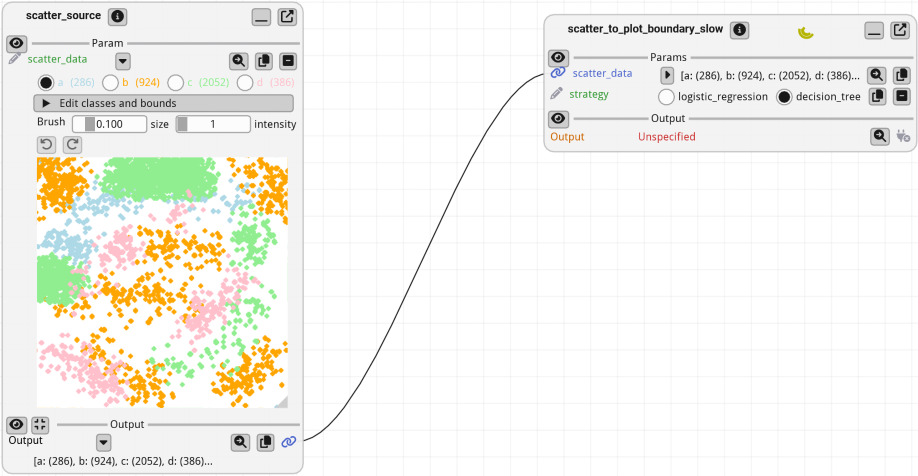

In [8]:

@fl.with_fiat_attributes(
    invoke_async=True,  # The function will be executed asynchronously
    # invoke_manually=True,  # The function will not be executed automatically (the user will have to click on the button)
    # invoke_always_dirty = True # The function will be executed even if the inputs are not dirty
)
def scatter_to_plot_boundary_slow(scatter_data: ScatterData, strategy: DecisionStrategy) -> Figure | None:
    """An artificially slow version of scatter_to_plot_boundary"""
    time.sleep(5)
    return plot_boundary(scatter_data.data_as_pandas(), strategy=strategy, eps=0.1)


fl.run([scatter_source, scatter_to_plot_boundary_slow], app_name="slow_plot_boundary")

# What if I want to distribute a part of this notebook as a standalone application?

_Each of the Fiatlight cells you saw in this notebook is a mini-application, packed with powerful features:_


**Save/load user inputs**

- **Save/load user inputs:** if you launched an app with `fl.run(..., app_name="my_app")`, you can find the saved state in 3 files stored under `fiat_settings/my_app.*`. Simply distribute these files with your app, and the user will be able to load the state back in.
- **Save/load GUI options:** together with the user inputs, the GUI options are saved in the same files. This means that the user will see the function graph in the same state as when they saved it (e.g., with the same zoom level, the same plot size, etc.)
- **Save/load alternative states:** you can also save/load alternative states of the app (see file menu). This is useful if you want to show different results to the user, or if you want to show the user different options. Save the states wherever you want, and distribute them with your app.


**User experience**

- **Function doc:** you can add a documentation string to your function, and it will be shown in the app. Use markdown to format it as you like.
- **Documentation nodes**: you can add a standalone documentation nodes, in order to add more documentation to your app. You can even use the module's docstring to fill your documentation!
- **Explain usage:** you can add tooltips and documentation to parameters and functions. You can even rename how functions are presented.
- **Input validation:** Fiatlight support validators for parameters. Validators are small functions that check them, and may throw an error with an explanation message. In such a case, Fiatlight will display the message nicely to the user
- **Standalone gui nodes**: if needed, you can also add nodes whose intent is only to display additional GUI (or to change global state).


#### How to export as a an application

The code to run a Fiatlight application is extremely short. The cell below is an example of code which we can export to a runnable standalone Python file.

**Details**
- It was created, by copying the "imports" cell, and the "plot_boundary" function
- To illustrate the user experience, some attributes were added, as well as a documentation node 

---

**Notes**
- **Local Python installation required:** Running a fiatlight application requires a local Python installation. 
- **Or run as a webasm application:** As an alternative, apps can be also deployed to WebAsm (no local install required)
- **Markdown:** Markdown support is still limited 
- **Deploy**: Copy this cell below a standalone python file to create an app
- **This cell is long?** _This is for demonstration purposes only: it is an aggregation of the previous cells, with some added documentation._
  In a real world application, you would add modules to place your functions and utilities (such as DecisionStrategy and plot_boundary below)
- **Docstring**: The string below at the start of the cell is the docstring of the application, it will be displayed in a separate node, as a user documentation.


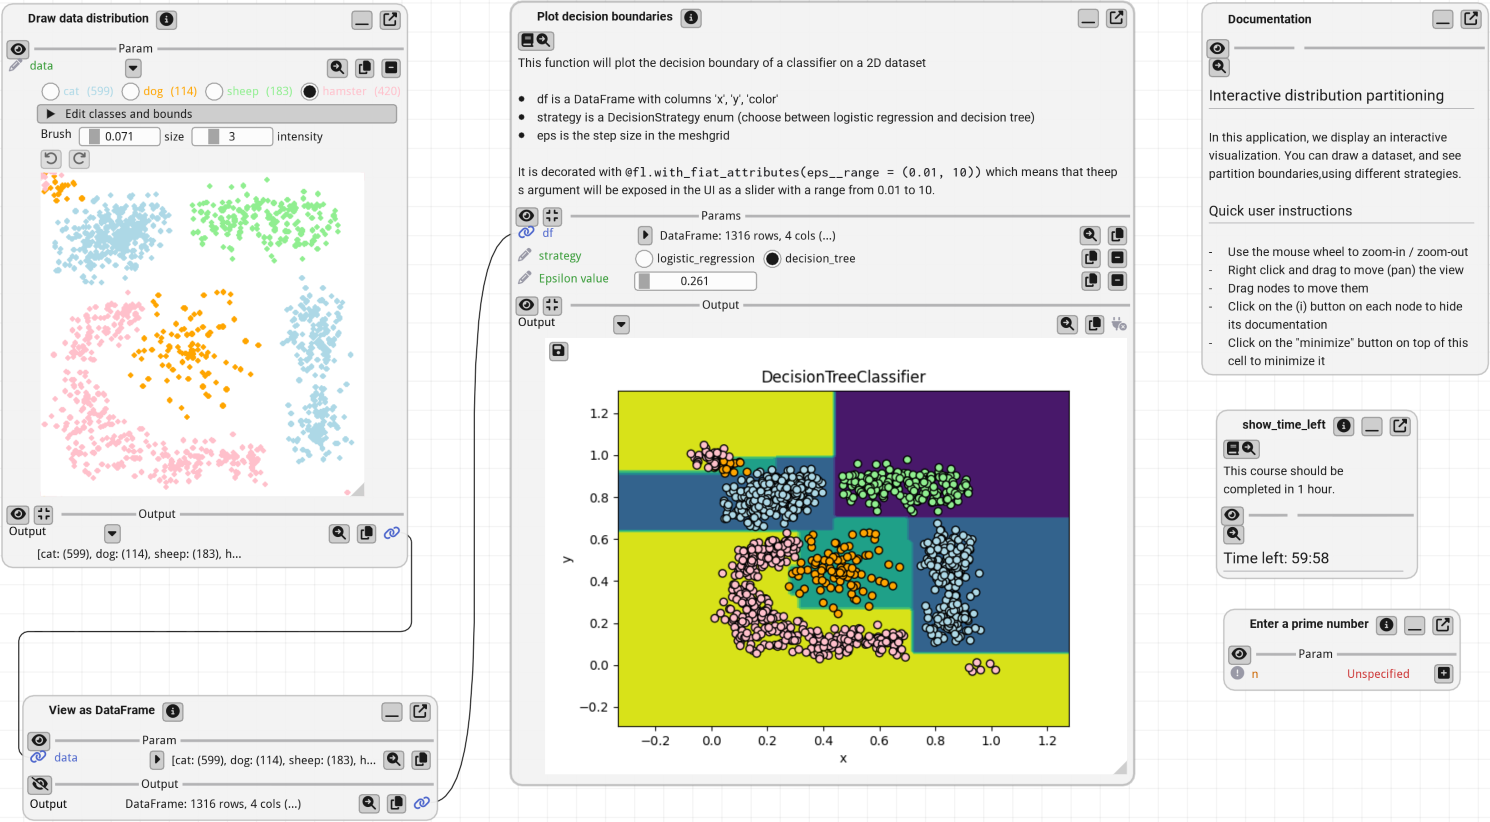

In [15]:
# Example of a standalone application
# ===================================
# Important notes:
#   - Copy this cell into a standalone python file to create an app
#   - This cell is long? This is for demonstration purposes only: it is an aggregation of the previous cells, with some added documentation
#     In a real world application, you would add modules to place your functions and utilities (such as DecisionStrategy and plot_boundary below)
#   - The string below is the docstring of the application, it will be displayed in a separate node, as a user documentation.

"""Interactive distribution partitioning
========================================
In this application, we display an interactive visualization. You can draw a dataset, and see partition boundaries,
using different strategies.

Quick user instructions
-----------------------
- Use the mouse wheel to zoom-in / zoom-out
- Right click and drag to move (pan) the view
- Drag nodes to move them
- Click on the (i) button on each node to hide its documentation
- Click on the "minimize" button on top of this cell to minimize it

"""

# Part 1: imports
# ---------------
import matplotlib ; matplotlib.use("Agg")  # setup step needed to integrate matplotlib in Fiatlight
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

import numpy as np
from enum import Enum
import pandas as pd
import time

# Specific imports for fiatlight
import fiatlight as fl
from scatter_widget_bundle import ScatterData


# Part 2: define the functions we want to use in the application
# --------------------------------------------------------------
# i. An enum used by plot_boundary to choose between logistic regression and decision tree
#    (Fiatlight will automatically convert this to radio buttons in the UI)
class DecisionStrategy(Enum):
    """This is a simple enum to choose between logistic regression and decision tree
    Fiatlight will automatically convert this to radio buttons in the UI
    """
    logistic_regression = LogisticRegression
    decision_tree = DecisionTreeClassifier


# ii. Below, we define a function that will plot the decision boundary of a classifier on a 2D dataset
#    It is decorated with `@fl.with_fiat_attributes`, where we specify the UI options
@fl.with_fiat_attributes(
    label = "Plot decision boundaries",  # label of the node in the UI
    strategy__label = "Choose strategy",  # label of the strategy argument in the UI
    strategy__tooltip = "you may choose between logistic and decision tree",  # tooltip for the strategy argument
    eps__label = "Epsilon value",  # label of the eps argument in the UI
    eps__tooltip = "Epsilon value used to draw the boundary",  # tooltip for the eps argument
    eps__range=(0.01, 10)  # range of the eps argument in the UI
)
def plot_boundary(
        df: pd.DataFrame,
        strategy: DecisionStrategy = DecisionStrategy.logistic_regression,
        eps: float = 1.0) -> Figure | None:
    """This function will plot the decision boundary of a classifier on a 2D dataset
    * df is a DataFrame with columns 'x', 'y', 'color'
    * strategy is a DecisionStrategy enum (choose between logistic regression and decision tree)
    * eps is the step size in the meshgrid

    It is decorated with `@fl.with_fiat_attributes(eps__range = (0.01, 10))` which means that the
    eps argument will be exposed in the UI as a slider with a range from 0.01 to 10.
    """
    if len(df) and (df['color'].nunique() > 1):
        X = df[['x', 'y']].values
        y = df['color']
        fig, ax = plt.subplots()
        if strategy == DecisionStrategy.logistic_regression:
            classifier = LogisticRegression().fit(X, y)
        else:
            classifier = DecisionTreeClassifier().fit(X, y)
        disp = DecisionBoundaryDisplay.from_estimator(
            classifier, X,
            response_method="predict_proba" if len(np.unique(df['color'])) == 2 else "predict",
            xlabel="x", ylabel="y",
            # alpha=0.5,
            eps=eps,
            ax=ax
        )
        disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
        ax.set_title(f"{classifier.__class__.__name__}")
        return fig
    else:
        return None


@fl.with_fiat_attributes(label = "Draw data distribution")
def scatter_source(data: ScatterData) -> ScatterData:
    """Draw the distribution of data below, using different classes.

    """
    return data


@fl.with_fiat_attributes(label="View as DataFrame")
def scatter_to_df(data: ScatterData) -> pd.DataFrame:
    """Expand this node output to see the dataframe.
    To expand it, click on the eye to the left of the output region.
    """
    return data.data_as_pandas()


# Part 3: add a standalone GUI node
# ---------------------------------
# In this contrived example, we show an imaginary "timer" for a course of a given duration
time_start = time.time()


# This function will be shown in the GUI
def show_time_left() -> None:
    """This course should be completed in 1 hour."""
    from imgui_bundle import imgui_md, imgui_color_text_edit as editor
    total_duration = 60 * 60  # Total duration in seconds (1 hour)
    elapsed_time = time.time() - time_start
    time_left = max(0., total_duration - elapsed_time)
    minutes, seconds = divmod(int(time_left), 60)
    imgui_md.render(f"# Time left: {minutes:02d}:{seconds:02d}")


# Part 4: demo of input validation
# --------------------------------
# This part is just a demo of input validation. We create a node that asks the user to enter a prime number.
# (it has no relation to the rest of the application)
def prime_validator(x: int) -> int:
    """This validator checks that the value is a prime number, and warns the user if it is not."""
    if x < 2:
        raise ValueError("Please enter a number greater than 1")
    for i in range(2, int(x ** 0.5) + 1):
        if x % i == 0:
            raise ValueError("Please enter a prime number")
    return x

@fl.with_fiat_attributes(
    label="Enter a prime number",
    n__validator = prime_validator
)
def enter_prime_number(n: int) -> None:
    """Enter a prime number.
    This node is just a demo of input validation.
    """
    pass


# Part 4: create the graph and run the application
# ------------------------------------------------
graph = fl.FunctionsGraph()  #
graph.add_function_composition([scatter_source, scatter_to_df, plot_boundary])  # Add a functions composition to the graph
graph.add_markdown_node(__doc__)  # Add a markdown node with the docstring of the application
graph.add_gui_node(show_time_left)  # Add a GUI node to show the time left
graph.add_function(enter_prime_number)  # Add a function node to enter a prime number
fl.run(graph, app_name="example_app")   # Run the application with the graph we created


# Quick note about `fiatlight` command line tool

The `fiatlight` command line tool enables to get more information about the available fiat attributes for a function.

```
> fiatlight fn_attrs
Available fiat attributes for FunctionWithGui:
--------------------------------------------------------------------------------
+---------------------+--------+-----------+------------------------------------------------+
| Name                | Type   | Default   | Explanation                                    |
+=====================+========+===========+================================================+
|                     |        |           | **Behavioral Flags**                           |
+---------------------+--------+-----------+------------------------------------------------+
| invoke_async        | bool   | False     | If True, the function shall be called          |
|                     |        |           | asynchronously                                 |
+---------------------+--------+-----------+------------------------------------------------+
| invoke_manually     | bool   | False     | If True, the function will be called only if   |
|                     |        |           | the user clicks on the 'invoke' button         |
+---------------------+--------+-----------+------------------------------------------------+
| invoke_always_dirty | bool   | False     | If True, the function output will always be    |
|                     |        |           | considered out of date, and   - if             |
|                     |        |           | invoke_manually is True, the 'Refresh needed'  |
|                     |        |           | label will be displayed  - if invoke_manually  |
|                     |        |           | is False, the function will be called at each  |
|                     |        |           | frame                                          |
+---------------------+--------+-----------+------------------------------------------------+
|                     |        |           | **Documentation**                              |
+---------------------+--------+-----------+------------------------------------------------+
| label               | str    |           | The display name of the function (will use the |
|                     |        |           | function name if empty)                        |
+---------------------+--------+-----------+------------------------------------------------+
| doc_display         | bool   | False     | If True, the doc string is displayed in the    |
|                     |        |           | GUI                                            |
+---------------------+--------+-----------+------------------------------------------------+
| doc_markdown        | bool   | True      | If True, the doc string is in Markdown format  |
+---------------------+--------+-----------+------------------------------------------------+
| doc_user            | str    |           | The documentation string. If not provided, the |
|                     |        |           | function docstring will be used                |
+---------------------+--------+-----------+------------------------------------------------+
| doc_show_source     | bool   | False     | If True, the source code of the function will  |
|                     |        |           | be displayed in the GUI                        |
+---------------------+--------+-----------+------------------------------------------------+

```